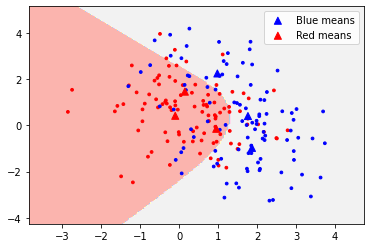

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(0) # For reproducability

blue_means = multivariate_normal.rvs(mean=(0, 0), cov=[[1,0],[0,1]], size=3)
red_means = multivariate_normal.rvs(mean=(0, 0), cov=[[1,0],[0,1]], size=3)

def sample_mixture(n, M):
    """Returns a sample of size n from a Gaussian mixture distribution that is the sum of 3 bivariate normal distributions with
    means m and identity variance-covariance matrix.
    """    
    mean_sample = np.random.choice(3, replace=True, size=n)
    
    sample = pd.DataFrame([multivariate_normal.rvs(mean=mu, cov=[[1,0],[0,1]], size=1) for mu in M[mean_sample]])

    return(sample)

def generate_points(n, M, label):
    """Generates n points from class label with a Gaussian mixture distribution with means M as described in sample_mixture.    
    """    
    points = sample_mixture(n, M)
    
    d = {'x': points[0], 'y': points[1], 'class': [label for i in range(n)]}
        
    newdata = pd.DataFrame(d)
    
    return(newdata)

def mesh_probability(x, y, mu, dx, dy):
    """Calculates the probability that Z is in (x, x + dx) x (y, y + dy) where Z is bivariate normal with mean mu and 
    variance covariance I.
    """
    prob = multivariate_normal.cdf((x + dx, y + dy), mean=mu) - multivariate_normal.cdf((x + dx, y), mean=mu) - \
    multivariate_normal.cdf((x, y + dy), mean=mu) + multivariate_normal.cdf((x, y), mean=mu)
    
    return(prob)


def bayes_classifier(data, dx, dy):
    """Returns the prediction for each point in data from a Bayes classifier using the Gaussian mixtures with means blue_means
    and red_means and variance-covariance I. Argument mesh_size is the side length of the mesh created to approximate the
    probabilities.
    """
    prediction = np.empty((xx.shape[0] * xx.shape[1], 1))
    
    for i in range(len(data)):
        blue_individual_probabilities = [0, 0, 0]
        red_individual_probabilities = [0, 0, 0]
        for j in range(3):
            red_individual_probabilities[j] = mesh_probability(data[i][0], data[i][1], red_means[j], dx, dy)
            blue_individual_probabilities[j] = mesh_probability(data[i][0], data[i][1], blue_means[j], dx, dy)       
        red_total_probability = sum(red_individual_probabilities) / 3
        blue_total_probability = sum(blue_individual_probabilities) / 3
        if red_total_probability >= blue_total_probability:
            prediction[i] = 0
        else:
            prediction[i] = 1
    
    return(prediction)

# Generate 100 points belonging to the each class.
df = generate_points(100, red_means, 'red').append(generate_points(100, blue_means, 'blue'))

# Create grid of the region containing the observations in order to classify them.
x_min, x_max = df['x'].min() - 1, df['x'].max() + 1
y_min, y_max = df['y'].min() - 1, df['y'].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))

Z = bayes_classifier(np.c_[xx.ravel(), yy.ravel()], .05, .05)

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

# Plot the generated points
plt.scatter(df['x'], df['y'], c=df['class'], marker='.', s=30)

# Plot the means
plt.scatter([x[0] for x in blue_means], [x[1] for x in blue_means], c=['blue' for x in range(3)], marker='^', s=50,\
            label="Blue means")
plt.scatter([x[0] for x in red_means], [x[1] for x in red_means], c=['red' for x in range(3)], marker='^', s=50,\
            label="Red means")

# Include a legend
plt.legend(loc="upper right")

plt.savefig('Bayes Classifier Simulation.png')
